In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [17]:
# import dataset

df = pd.read_csv('dataset/Womens Clothing E-Commerce Reviews.csv')
df.head()

# dataset: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
col = ['Review Text', 'Department Name']
df = df[col]

df.isnull().sum()

Review Text        845
Department Name     14
dtype: int64

In [4]:
df = df.dropna()

df.isnull().sum()

Review Text        0
Department Name    0
dtype: int64

In [5]:
df.columns = ['review', 'department']
df['department_id'] = df['department'].factorize()[0]

df.head()

,review,department,department_id
0,Absolutely wonderful - silky and sexy and comf...,Intimate,0
1,Love this dress! it's sooo pretty. i happene...,Dresses,1
2,I had such high hopes for this dress and reall...,Dresses,1
3,"I love, love, love this jumpsuit. it's fun, fl...",Bottoms,2
4,This shirt is very flattering to all due to th...,Tops,3


In [6]:
encoded_data, mapping_index = df['department'].factorize()
print(encoded_data)
print(mapping_index)

[0 1 1 ... 1 1 1]
Index([u'Intimate', u'Dresses', u'Bottoms', u'Tops', u'Jackets', u'Trend'], dtype='object')


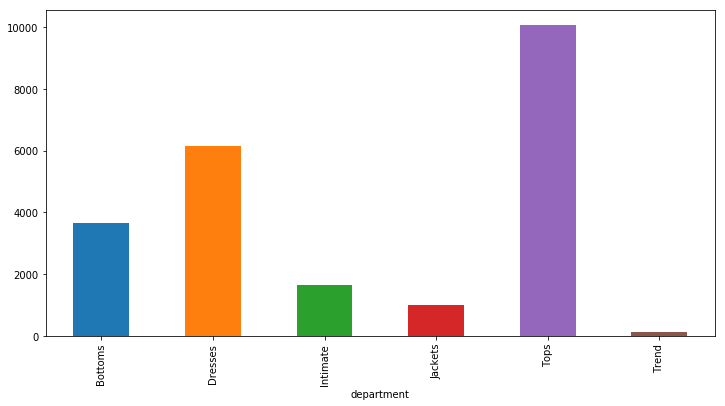

In [7]:
fig = plt.figure(figsize=(12,6))
df.groupby('department').review.count().plot.bar()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=5, 
    norm='l2',
    encoding='latin-1',
    ngram_range=(1,2),
    stop_words='english'
)

features = tfidf.fit_transform(df.review).toarray()
labels = df.department_id

features.shape

(22628L, 21398L)

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(
    df['review'], 
    df['department_id'],
    random_state=0
)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [111]:
df.sample(3)

,review,department,department_id
8316,These are so great! love the fabric weight ( l...,Bottoms,2
15108,I love white blouses in the summer. this one i...,Tops,3
4433,"Cute, easy fitting dress. i got it in orange, ...",Dresses,1


In [114]:
print(df.review[8316])
print(df.review[4433])

These are so great! love the fabric weight ( light ) they look great on - the pictures don't do these justice! i tried them on in the store with a black sleeveless crop top (you couldn't see any mid skin) and it looked great together, might have to go back and get the top! they do look great with just a black tank as well though!
Cute, easy fitting dress. i got it in orange, which is a summery, pretty print. i ordered it in petite because i am 5'1", but the dress is very short, so i'm exchanging it for a regular size. if you're average height, be aware that the dress will be well above the knee.


In [115]:
pred = clf.predict(count_vect.transform([df.review[15108]]))

print(mapping_index[pred])[0]

Tops


In [113]:
pred = clf.predict(count_vect.transform([df.review[4433]]))

print(mapping_index[pred])[0]

Dresses


==============================================================

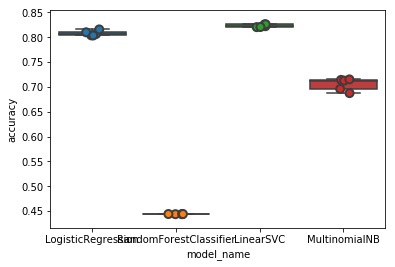

In [118]:
# find the best model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=200,max_depth=3,random_state=0),
    LinearSVC(),
    MultinomialNB()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [119]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.823140
LogisticRegression        0.808026
MultinomialNB             0.705143
RandomForestClassifier    0.444052
Name: accuracy, dtype: float64

==============================================================

In [12]:
# df['department_id'] = df['department'].factorize()[0]
department_id_df = df[['department', 'department_id']].drop_duplicates().sort_values('department_id')
department_to_id = dict(department_id_df.values)
id_to_department = dict(department_id_df[['department_id', 'department']].values)
df.head()

,review,department,department_id
0,Absolutely wonderful - silky and sexy and comf...,Intimate,0
1,Love this dress! it's sooo pretty. i happene...,Dresses,1
2,I had such high hopes for this dress and reall...,Dresses,1
3,"I love, love, love this jumpsuit. it's fun, fl...",Bottoms,2
4,This shirt is very flattering to all due to th...,Tops,3


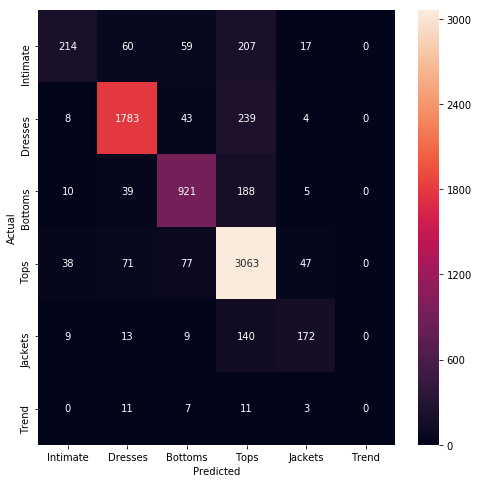

In [14]:
from sklearn.svm import LinearSVC
import seaborn as sns

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=department_id_df.department.values, yticklabels=department_id_df.department.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['department'].unique()))

             precision    recall  f1-score   support

   Intimate       0.77      0.38      0.51       557
    Dresses       0.90      0.86      0.88      2077
    Bottoms       0.83      0.79      0.81      1163
       Tops       0.80      0.93      0.86      3296
    Jackets       0.69      0.50      0.58       343
      Trend       0.00      0.00      0.00        32

avg / total       0.82      0.82      0.81      7468



inspired by: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f